<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Optimize_Pytorch_Lightning_models_with_Weights_&_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{pytorch-lightning-colab} -->

<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{pytorch-lightning-colab} -->

# ⚡ Pytorch Lightning models with Weights & Biases

Pytorch Lightning is a lightweight wrapper for organizing your PyTorch code and easily adding advanced features such as distributed training, 16-bit precision or gradient accumulation.

Coupled with the [Weights & Biases integration](https://docs.wandb.com/library/integrations/lightning), you can quickly train and monitor models for full traceability and reproducibility with only 2 extra lines of code:

```python
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger()
trainer = Trainer(logger=wandb_logger)
```

W&B integration with Pytorch-Lightning can automatically:
* log your configuration parameters
* log your losses and metrics
* log your model
* keep track of your code
* log your system metrics (GPU, CPU, memory, temperature, etc)

### 📚 Docs
You can find the PyTorch Lightning WandbLogger docs [here](https://pytorch-lightning.readthedocs.io/en/latest/extensions/generated/pytorch_lightning.loggers.WandbLogger.html?highlight=wandblogger) and the Weights & Biases docs [here](https://docs.wandb.com/library/integrations/lightning)

### 🛠️ Installation and set-up

In [ ]:
!pip install -q pytorch-lightning wandb

We make sure we're logged into W&B so that our experiments can be associated with our account.

In [ ]:
import wandb
wandb.login()

## 📊 Setting up the dataloader

For the context of this tutorial we use vanilla pytorch dataloaders on the MNIST dataset

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

dataset = MNIST(root="./MNIST", download=True, transform=transform)
training_set, validation_set = random_split(dataset, [55000, 5000])

In [ ]:
training_loader = DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=64)

## 🤓 Defining the Model

**Tips**:
* Call `self.save_hyperparameters()` in `__init__` to automatically log your hyperparameters to **W&B**
* Call self.log in `training_step` and `validation_step` to log the metrics

In [ ]:
import torch
from torch.nn import Linear, CrossEntropyLoss, functional as F
from torch.optim import Adam
from torchmetrics.functional import accuracy
from pytorch_lightning import LightningModule

class MNIST_LitModule(LightningModule):

    def __init__(self, n_classes=10, n_layer_1=128, n_layer_2=256, lr=1e-3):
        '''method used to define our model parameters'''
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = Linear(28 * 28, n_layer_1)
        self.layer_2 = Linear(n_layer_1, n_layer_2)
        self.layer_3 = Linear(n_layer_2, n_classes)

        # loss
        self.loss = CrossEntropyLoss()

        # optimizer parameters
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

    def forward(self, x):
        '''method used for inference input -> output'''

        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # let's do 3 x (linear + relu)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)
    
    def configure_optimizers(self):
        '''defines model optimizer'''
        return Adam(self.parameters(), lr=self.lr)
    
    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y)
        return preds, loss, acc

The model is now ready!

In [ ]:
model = MNIST_LitModule(n_layer_1=128, n_layer_2=128)

## 💾 Save Model Checkpoints

The `ModelCheckpoint` callback is required along with the `WandbLogger` argument to log model checkpoints to W&B.

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

## 💡 Tracking Experiments with WandbLogger

PyTorch Lightning has a `WandbLogger` to easily log your experiments with Wights & Biases. Just pass it to your `Trainer` to log to W&B. See the [WandbLogger docs](https://pytorch-lightning.readthedocs.io/en/stable/extensions/generated/pytorch_lightning.loggers.WandbLogger.html#pytorch_lightning.loggers.WandbLogger) for all parameters. Note, to log the metrics to a specific W&B Team, pass your Team name to the `entity` argument in `WandbLogger`

#### `pytorch_lightning.loggers.WandbLogger()`

| Functionality | Argument/Function | PS |
| ------ | ------ | ------ |
| Logging models | `WandbLogger(... ,log_model='all')` or `WandbLogger(... ,log_model=True`) | Log all models if `log_model="all"` and at end of training if `log_model=True`
| Set custom run names | `WandbLogger(... ,name='my_run_name'`) | |
| Organize runs by project | `WandbLogger(... ,project='my_project')` | |
| Log histograms of gradients and parameters | `WandbLogger.watch(model)`  | `WandbLogger.watch(model, log='all')` to log parameter histograms  |
| Log hyperparameters | Call `self.save_hyperparameters()` within `LightningModule.__init__()` |
| Log custom objects (images, audio, video, molecules…) | Use `WandbLogger.log_text`, `WandbLogger.log_image` and `WandbLogger.log_table` |

See the [WandbLogger docs](https://pytorch-lightning.readthedocs.io/en/stable/extensions/generated/pytorch_lightning.loggers.WandbLogger.html#pytorch_lightning.loggers.WandbLogger) here for all parameters. 

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger(project='MNIST', # group runs in "MNIST" project
                           log_model='all') # log all new checkpoints during training

## ⚙️ Using WandbLogger to log Images, Text and More
Pytorch Lightning is extensible through its callback system. We can create a custom callback to automatically log sample predictions during validation. `WandbLogger` provides convenient media logging functions:
* `WandbLogger.log_text` for text data
* `WandbLogger.log_image` for images
* `WandbLogger.log_table` for [W&B Tables](https://docs.wandb.ai/guides/data-vis).

An alternate to `self.log` in the Model class is directly using `wandb.log({dict})` or `trainer.logger.experiment.log({dict})`

In this case we log the first 20 images in the first batch of the validation dataset along with the predicted and ground truth labels.

In [ ]:
from pytorch_lightning.callbacks import Callback
 
class LogPredictionsCallback(Callback):
    
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        # Let's log 20 sample image predictions from first batch
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]
            
            # Option 1: log images with `WandbLogger.log_image`
            wandb_logger.log_image(key='sample_images', images=images, caption=captions)

            # Option 2: log predictions as a Table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            wandb_logger.log_table(key='sample_table', columns=columns, data=data)

log_predictions_callback = LogPredictionsCallback()

## 🏋️‍ Train Your Model

In [ ]:
trainer = Trainer(
    logger=wandb_logger,                    # W&B integration
    callbacks=[log_predictions_callback,    # logging of sample predictions
               checkpoint_callback],        # our model checkpoint callback
    max_epochs=5)                           # number of epochs

In [ ]:
trainer.fit(model, training_loader, validation_loader)

When we want to close our W&B run, we call `wandb.finish()` (mainly useful in notebooks, called automatically in scripts).

In [ ]:
wandb.finish()

We can monitor losses, metrics, gradients, parameters and sample predictions as the model trains.

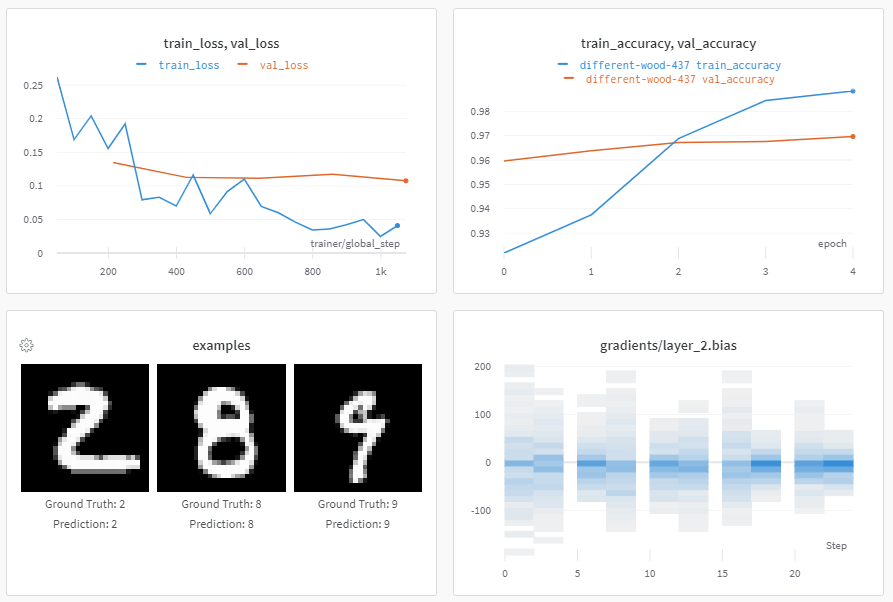

## 📚 Resources

* [Pytorch Lightning and W&B integration documentation](https://docs.wandb.ai/integrations/lightning) contains a few tips for taking most advantage of W&B
* [Pytorch Lightning documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/loggers.html#weights-and-biases) is extremely thorough and full of examples

## ❓ Questions about W&B

If you have any questions about using W&B to track your model performance and predictions, please contact support@wandb.com